In [1]:
## predict age with brain imaging features
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
print(mpl.__version__)
#from time import time

feature_name = 'Multi-modal'
# feature_name = 'GMV&DTI'
# feature_name = 'GMV&rsfMRI'

# result_table = pd.read_csv("result/disorders/out02_scatter_data_" + feature_name + "_fit_brainage_ridge.csv", 
#                            delimiter = ",", index_col = [0,1])
# print(result_table.shape)
# method = 'Ridge'

# result_table = pd.read_csv("result/disorders/out02_scatter_data_" + feature_name + "_fit_brainage_gpr.csv", delimiter = ",", index_col = [0,1])
# print(result_table.shape)
# method = 'GPR'

result_table = pd.read_csv("result/disorders/out02_scatter_data_" + feature_name + "_fit_brainage_svr.csv", delimiter = ",", index_col = [0,1])
print(result_table.shape)
method = 'SVR'

# result_table = pd.read_csv("result/disorders/out02_scatter_data_" + feature_name + "_fit_brainage_dnn.csv", delimiter = ",", index_col = [0,1])
# method = 'DNN'

subject_info_merge = pd.read_csv("data/script01_disorders_subject_info_merge.csv", delimiter = ",", index_col = 0)

result_table.drop(index = ['smry_agr', 'smry_dep'], axis = 0, level = 0, inplace = True)
print(result_table.shape)



# disorders = ['smry_dep', 'smry_phb',
#              'smry_soc', 'smry_agr']

# disorders = result_ridge.index.get_level_values(0)
disorders = result_table.index.unique(level = 0)
#disorders_name = [ 'Depression', 'Specific Phobia', 'PTSD', 'Social Phobia', 'Agroaphobia']
disorders_name = [ 'HC', 'Specific Phobia', 'PTSD', 'Social Phobia']
print(disorders)


2.2.2
(536, 4)
(441, 4)
Index(['HC', 'smry_phb', 'smry_ptd', 'smry_soc'], dtype='object', name='group')


In [2]:
# t-test of age difference between disorder and hc group:
from mlxtend.evaluate import permutation_test

subject_info_columns = ['SUBJID', 'Sex', 'age_at_cnb']
subject_info_hc = subject_info_merge.loc[subject_info_merge["mental_hc1"]==True, subject_info_columns]
print(subject_info_hc.shape)

age_hc = subject_info_hc["age_at_cnb"].values
disorders_age = []
disorders_ttest = []

for i_dis in range(len(disorders)):
    age_dis = result_table.loc[disorders[i_dis]]["age"]
    
    m = np.mean(age_dis.values) - np.mean(age_hc) 
    p_dis = permutation_test(age_dis, age_hc, method='approximate',num_rounds=1000,seed=0)
    print(disorders[i_dis] + ' vs hc: m = %3f, p = %.3f' % (m, p_dis))
    
    age_dis = age_dis.to_frame('age')
    disorders_age.append(age_dis)
    disorders_ttest.append((m, p_dis))



(52, 3)
HC vs hc: m = -0.217949, p = 0.755
smry_phb vs hc: m = -1.013736, p = 0.046
smry_ptd vs hc: m = 1.082051, p = 0.098
smry_soc vs hc: m = -0.116630, p = 0.817


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

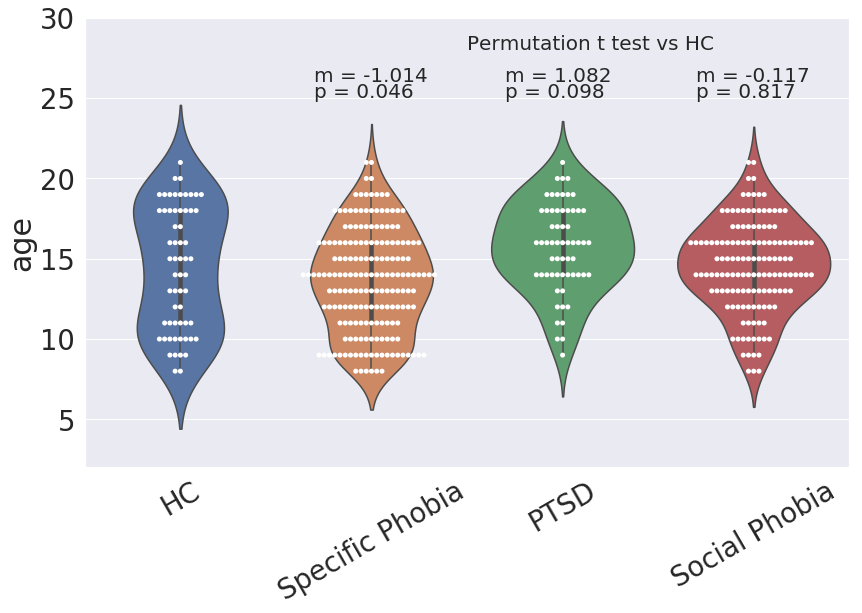

In [3]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(13.7,8.27)})

age_plot = pd.concat(disorders_age, axis = 0, keys = disorders_name)

age_plot = age_plot.reset_index().iloc[:, [0,2]]
age_plot.columns = ['group', 'age']

sns.set(font_scale=2.5)
ax = sns.violinplot(y = "age", x = "group", data = age_plot, bw = 'silverman')
ax = sns.swarmplot(y="age", x= "group", data=age_plot, color="white")
ax.set_ylim(2,30)

ax.text(2-.5, 28, 'Permutation t test vs HC', fontsize = 20)
for itxt in range(1, len(disorders_ttest)):
    
    txt1 = "p = %.3f" % disorders_ttest[itxt][1]
    ax.text(-.3+itxt, 25, txt1, fontsize = 20)
    
    txt1 = "m = %.3f" % disorders_ttest[itxt][0]
    ax.text(-.3+itxt, 26, txt1, fontsize = 20)

ax.set(ylabel="age", xlabel='')
#plt.title("Ridge")
# ax.set_xticklabels(labels=['HC']+disorders_name)
plt.xticks(rotation = 30)

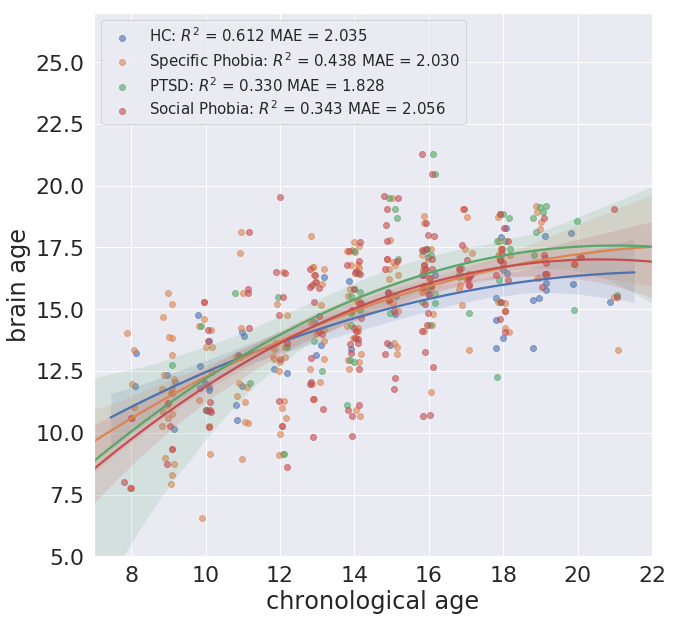

In [4]:
import seaborn as sns
from my_fun import qudratic_r_squared

sns.set(rc={'figure.figsize':(10,10)})
sns.set(color_codes=True)
sns.set(font_scale = 2)
plt.figure()

for i_dis in range(len(disorders)):
    
    y_dis = result_table.loc[tuple([disorders[i_dis]] + ['age'])]
    y_pred = result_table.loc[tuple([disorders[i_dis]] + ['predict age'])]
    
    r_dis = np.corrcoef(y_dis, y_pred)
    r_squared = qudratic_r_squared(y_dis, y_pred)
    rmse_dis = np.sqrt(np.mean(np.square(y_dis - y_pred)))
    mae_dis = np.mean(np.abs(y_dis - y_pred))
    
    #label = disorders[i_dis] + ": r = %.3f MAE = %.3f" % (r_dis[1,0], mae_dis)
    label = disorders_name[i_dis] + ": $R^2$ = %.3f MAE = %.3f" % (r_squared, mae_dis)
    
    ax = sns.regplot(x=y_dis, y=y_pred, label = label, order = 2, scatter_kws = {'alpha': .6}, x_jitter = .2)
    ax.legend(loc="upper left", fontsize = 15, labelspacing = .3)
    #ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
    ax.set(xlabel='chronological age', ylabel='brain age')
    ax.set(ylim = [5, 27])
    ax.set(xlim = [7, 22])
    #plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
    #plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title



HC vs 0: m = 0.022, std = 2.535, p = 0.95200
smry_phb vs 0: m = 0.804, std = 2.474, p = 0.00000
smry_ptd vs 0: m = 0.281, std = 2.400, p = 0.37700
smry_soc vs 0: m = 0.444, std = 2.545, p = 0.04600


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

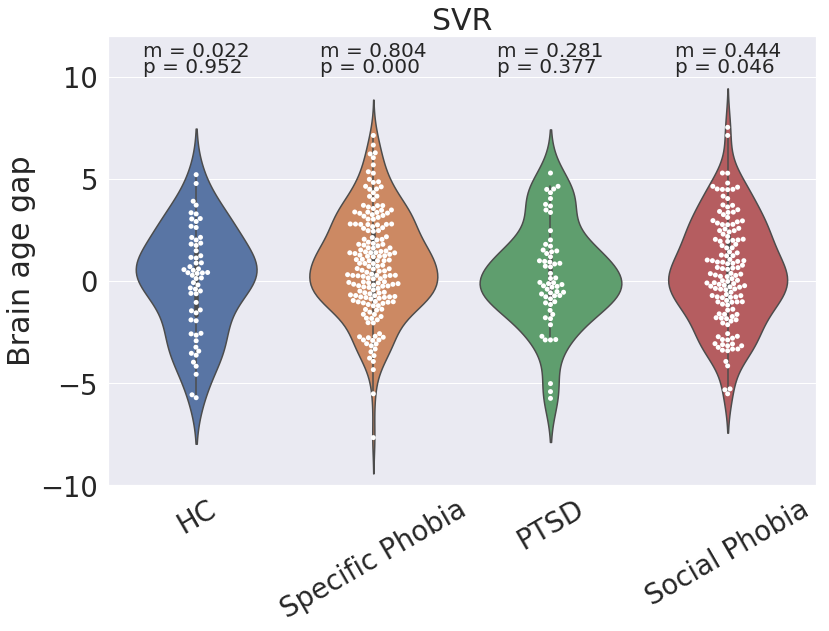

In [5]:
#permutation test of brain age gap:
from mlxtend.evaluate import permutation_test

def exact_mc_perm_test1(xs, nmc):
    import numpy as np
    
    n = len(xs)
    dbar = np.mean(xs)
    #absx <- np.abs(xs)
    z = []
    for i in range(nmc):
        mn = np.random.choice([-1,1],n)
        xbardash = np.mean(mn*np.abs(xs))
        z.append(xbardash)
    
    pval = (np.sum(z >= np.abs(dbar)) + np.sum(z <= -np.abs(dbar)))/nmc
    return(pval)

y_dis = result_table.loc['HC', 'age']
y_pred = result_table.loc['HC', 'predict age']

age_gap_hc = 1*(y_pred - y_dis)

age_gap_list = []
p_age_gap_list = []

for i_dis in range(len(disorders)):
    y_dis = result_table.loc[disorders[i_dis], 'age']
    y_pred = result_table.loc[disorders[i_dis], 'predict age']
    
    age_gap = 1*(y_pred - y_dis)

    p_age_gap = permutation_test(age_gap, age_gap_hc, method='approximate',num_rounds=1000,seed=7)
    np.random.seed(7)
    p_age_gap = exact_mc_perm_test1(age_gap, 1000)
    age_gap_list.append(pd.DataFrame(age_gap))
    p_age_gap_list.append(p_age_gap)
    
    print(disorders[i_dis] + ' vs 0: m = %.3f, std = %.3f, p = %.5f' % (np.mean(age_gap), np.std(age_gap), p_age_gap))


sns.set(rc={'figure.figsize':(12.7,8.27)})
plot_data = pd.concat(age_gap_list, axis = 0, keys = disorders)
plot_data = plot_data.reset_index().iloc[:,[0,2]]
plot_data.columns = ['disorder', 'brain age gap']
# print(plot_data)
sns.set(font_scale=2.5)
ax = sns.violinplot(y = "brain age gap", x = "disorder", data = plot_data)
# ax = sns.boxplot(y = "residual", x = "group", data = df)
ax = sns.swarmplot(y = "brain age gap", x = "disorder", data = plot_data, color="white")
ax.set_ylim(-10, 12)

for itxt in range(len(p_age_gap_list)):
    
    txt1 = "p = %.3f" % p_age_gap_list[itxt] 
    ax.text(-.3+itxt, 10.2, txt1, fontsize = 20)
    
    txt1 = "m = %.3f" % age_gap_list[itxt].mean()
    ax.text(-.3+itxt, 11, txt1, fontsize = 20)

ax.set(ylabel="Brain age gap", xlabel="")
ax.set_xticklabels(labels=disorders_name)
plt.title(method)
plt.xticks(rotation = 30)


#plt.savefig('boxplot_ptsd_trauma_age_prediction_' + file_name_tail + '.pdf', bbox_inches='tight')
#plt.savefig('boxplot_ptsd_trauma_age_prediction_' + file_name_tail + '.eps', format = "eps", dpi = 300, bbox_inches='tight')

HC vs 0: m = -0.000, std = 1.172, p = 1.00000
smry_phb vs 0: m = 0.022, std = 1.941, p = 0.94700
smry_ptd vs 0: m = 0.660, std = 1.980, p = 0.03800
smry_soc vs 0: m = 0.189, std = 2.137, p = 0.52600


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

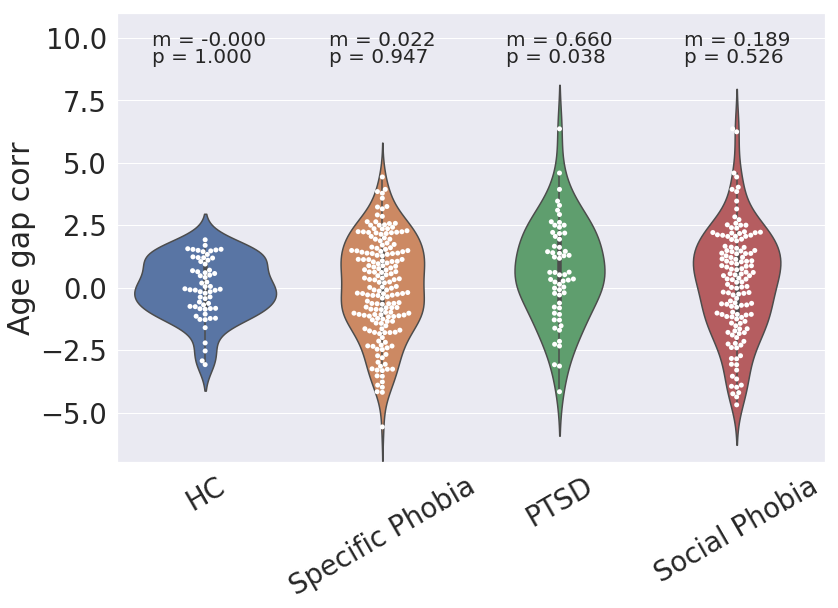

In [6]:
#permutation test of brain age gap corrected:
# from mlxtend.evaluate import permutation_test

# def exact_mc_perm_test1(xs, nmc):
#     import numpy as np
    
#     n = len(xs)
#     dbar = np.mean(xs)
#     #absx <- np.abs(xs)
#     z = []
#     for i in range(nmc):
#         mn = np.random.choice([-1,1],n)
#         xbardash = np.mean(mn*np.abs(xs))
#         z.append(xbardash)
    
#     pval = (np.sum(z >= np.abs(dbar)) + np.sum(z <= -np.abs(dbar)))/nmc
#     return(pval)

age_gap_list = []
p_age_gap_list = []

y_dis = result_table.loc['HC', 'brain age fit']
y_pred = result_table.loc['HC', 'predict age']

age_gap_hc = 1*(y_pred - y_dis)


for i_dis in range(len(disorders)):
    
    y_dis = result_table.loc[disorders[i_dis], 'brain age fit']
    y_pred = result_table.loc[disorders[i_dis], 'predict age']
    
    age_gap = 1*(y_pred - y_dis)

    p_age_gap = permutation_test(age_gap, age_gap_hc, method='approximate',num_rounds=1000,seed=7)
    np.random.seed(7)
    #p_age_gap = exact_mc_perm_test1(age_gap, 1000)
    age_gap_list.append(pd.DataFrame(age_gap))
    p_age_gap_list.append(p_age_gap)
    
    print(disorders[i_dis] + ' vs 0: m = %.3f, std = %.3f, p = %.5f' % (np.mean(age_gap), np.std(age_gap), p_age_gap))


sns.set(rc={'figure.figsize':(12.7,8.27)})
plot_data = pd.concat(age_gap_list, axis = 0, keys = disorders)
plot_data = plot_data.reset_index().iloc[:,[0,2]]
plot_data.columns = ['disorder', 'brain age gap']
# print(plot_data)
sns.set(font_scale=2.5)
ax = sns.violinplot(y = "brain age gap", x = "disorder", data = plot_data)
# ax = sns.boxplot(y = "residual", x = "group", data = df)
ax = sns.swarmplot(y = "brain age gap", x = "disorder", data = plot_data, color="white")
ax.set_ylim(-7, 11)

for itxt in range(len(p_age_gap_list)):
    
    txt1 = "p = %.3f" % p_age_gap_list[itxt] 
    ax.text(-.3+itxt, 9, txt1, fontsize = 20)
    
    txt1 = "m = %.3f" % age_gap_list[itxt].mean()
    ax.text(-.3+itxt, 9.7, txt1, fontsize = 20)

ax.set(ylabel="Age gap corr", xlabel="")
ax.set_xticklabels(labels=disorders_name)
# plt.title(method)
plt.xticks(rotation = 30)


#plt.savefig('boxplot_ptsd_trauma_age_prediction_' + file_name_tail + '.pdf', bbox_inches='tight')
#plt.savefig('boxplot_ptsd_trauma_age_prediction_' + file_name_tail + '.eps', format = "eps", dpi = 300, bbox_inches='tight')

# brain age gap for sub-group:

HC vs 0: m = 0.089, std = 1.220, p = 1.00000
smry_phb vs 0: m = 0.398, std = 1.645, p = 0.31500
smry_ptd vs 0: m = 0.821, std = 1.915, p = 0.04300
smry_soc vs 0: m = 0.325, std = 1.976, p = 0.47400


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

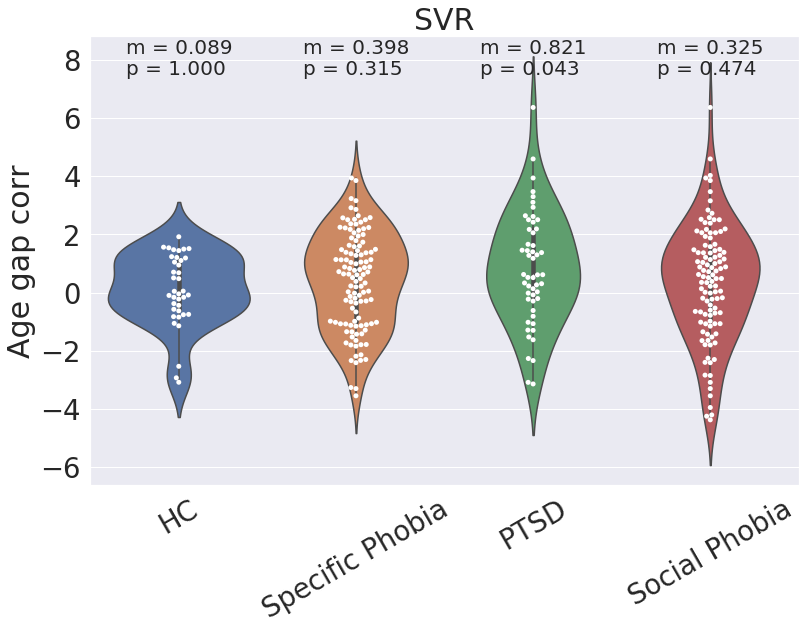

In [7]:
#permutation test of brain age gap corrected:
# from mlxtend.evaluate import permutation_test

# def exact_mc_perm_test1(xs, nmc):
#     import numpy as np
    
#     n = len(xs)
#     dbar = np.mean(xs)
#     #absx <- np.abs(xs)
#     z = []
#     for i in range(nmc):
#         mn = np.random.choice([-1,1],n)
#         xbardash = np.mean(mn*np.abs(xs))
#         z.append(xbardash)
    
#     pval = (np.sum(z >= np.abs(dbar)) + np.sum(z <= -np.abs(dbar)))/nmc
#     return(pval)

age_gap_list = []
p_age_gap_list = []

age_thresh = 12
result_table_sub = result_table.loc[result_table['age']>age_thresh, :]

y_dis = result_table_sub.loc['HC', 'brain age fit']
y_pred = result_table_sub.loc['HC', 'predict age']

age_gap_hc = 1*(y_pred - y_dis)

for i_dis in range(len(disorders)):
    y_dis = result_table_sub.loc[disorders[i_dis], 'brain age fit']
    y_pred = result_table_sub.loc[disorders[i_dis], 'predict age']
    
    age_gap = 1*(y_pred - y_dis)

    p_age_gap = permutation_test(age_gap, age_gap_hc, method='approximate',num_rounds=1000,seed=7)
    np.random.seed(7)
    #p_age_gap = exact_mc_perm_test1(age_gap, 1000)
    age_gap_list.append(pd.DataFrame(age_gap))
    p_age_gap_list.append(p_age_gap)
    
    print(disorders[i_dis] + ' vs 0: m = %.3f, std = %.3f, p = %.5f' % (np.mean(age_gap), np.std(age_gap), p_age_gap))


sns.set(rc={'figure.figsize':(12.7,8.27)})
plot_data = pd.concat(age_gap_list, axis = 0, keys = disorders)
plot_data = plot_data.reset_index().iloc[:,[0,2]]
plot_data.columns = ['disorder', 'brain age gap']
# print(plot_data)
sns.set(font_scale=2.5)
ax = sns.violinplot(y = "brain age gap", x = "disorder", data = plot_data)
# ax = sns.boxplot(y = "residual", x = "group", data = df)
ax = sns.swarmplot(y = "brain age gap", x = "disorder", data = plot_data, color="white")
# ax.set_ylim(-6.5, 6.5)

for itxt in range(len(p_age_gap_list)):
    
    txt1 = "p = %.3f" % p_age_gap_list[itxt] 
    ax.text(-.3+itxt, 7.5, txt1, fontsize = 20)
    
    txt1 = "m = %.3f" % age_gap_list[itxt].mean()
    ax.text(-.3+itxt, 8.2, txt1, fontsize = 20)

ax.set(ylabel="Age gap corr", xlabel="")
ax.set_xticklabels(labels=disorders_name)
plt.title(method)
plt.xticks(rotation = 30)


#plt.savefig('boxplot_ptsd_trauma_age_prediction_' + file_name_tail + '.pdf', bbox_inches='tight')
#plt.savefig('boxplot_ptsd_trauma_age_prediction_' + file_name_tail + '.eps', format = "eps", dpi = 300, bbox_inches='tight')

In [8]:
# define label for hehavioral scores:

# accuracy_col = [
#     "ABF_A_ar_z", "ATT_A_ar_z", "WM_A_ar_z", 
#     "VMEM_A_ar_z", "FMEM_A_ar_z", "SMEM_A_ar_z", 
#     "LAN_A_ar_z", "NVR_A_ar_z", "SPA_A_ar_z", 
#     "EID_A_ar_z", "EDI_A_ar_z", "ADI_A_ar_z"]

# speed_col = [
#     "ABF_S_ar_z", "ATT_S_ar_z", "WM_S_ar_z", 
#     "VMEM_S_ar_z", "FMEM_S_ar_z", "SMEM_S_ar_z", 
#     "LAN_S_ar_z", "NVR_S_ar_z", "SPA_S_ar_z", 
#     "EID_S_ar_z", "EDI_S_ar_z", "ADI_S_ar_z", 
#     "MOT_S_ar_z", "SM_S_ar_z"]

# cog_score_label = accuracy_col + speed_col

cog_label_acc = [
    # executive control:
    "pcet_acc2",
    "pcpt_t_tp",
    "lnb_tp2",
    # episodic memory task:
    "pwmt_kiwrd_tot",
    "pfmt_ifac_tot",
    "volt_svt",
    # complex cognitive task:
    "pvrt_cr",
    "pmat_cr",
    "plot_tc",
    # social cognition task:
    "peit_cr",
    "pedt_a",
    "padt_a"
]

cog_label_speed = [
    # executive control:
    "pcet_rtcr",
    "pcpt_t_tprt",
    "lnb_rtc2",
    # episodic memory task:
    "pwmt_kiwrd_rtc",
    "pfmt_ifac_rtc",
    "volt_svtcrt",
    # complex cognitive task:
    "pvrt_rtcr",
    "pmat_rtcr",
    "plot_tcrt",
    # social cognition task:
    "peit_crt",
    "pedt_t",
    "padt_t",
    # sensorimotor speed task:
    "mp_mp2rtcr",
    "tap_tot"
]

cog_label_acc2 = [
    # executive control:
    "ABF",
    "ATT",
    "WM",
    # episodic memory task:
    "VMEM",
    "FMEM",
    "SMEM",
    # complex cognitive task:
    "LAN",
    "NVR",
    "SPA",
    # social cognition task:
    "EID",
    "EDI",
    "ADI"
]

cog_label_speed2 = [
    # executive control:
    "ABF",
    "ATT",
    "WM",
    # episodic memory task:
    "VMEM",
    "FMEM",
    "SMEM",
    # complex cognitive task:
    "LAN",
    "NVR",
    "SPA",
    # social cognition task:
    "EID",
    "EDI",
    "ADI",
    # sensorimotor speed task:
    "MOT",
    "SM"
]

cog_score_label = cog_label_acc + cog_label_speed
cog_score_label2 = [s + '_Accuracy' for s in cog_label_acc2] + [s + '_Speed' for s in cog_label_speed2]
num_cog = len(cog_score_label)

In [9]:
# reading behavioral scores:
# read file with FA components:
#subject_behav = pd.read_csv("data/result_factor_analysis_pnc_data.csv", delimiter = ",")
#subject_behav = pd.read_csv("data/result01_pnc_data_merge.csv", delimiter = ",")
subject_behav = pd.read_csv("data/pyresult01_pnc_behav_mental.csv", delimiter = ",")
subject_behav = subject_behav.loc[:, ['SUBJID', 'Sex']+cog_score_label]
# print("subject_behav:")
# print(subject_behav[0:5])

# revert the last 2 cognitive scores:
subject_behav[["mp_mp2rtcr", "tap_tot"]] = subject_behav[["mp_mp2rtcr", "tap_tot"]]*(-1)

# print(subject_behav_merge[0:5])
# print(subject_behav_merge.shape)


/home/xin/environments/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
# merge behave file and subject info:
result_table_reset_index = result_table.reset_index()
subject_behav_merge = subject_behav.merge(result_table_reset_index, how = "inner", on = "SUBJID")
subject_behav_merge = subject_behav_merge.set_index('group')
# print(subject_behav_merge[0:5])
# print(subject_behav_merge.shape)

In [11]:
# compute correlation between brain age gap and behavioral scores

y_dis = subject_behav_merge.loc[:, 'brain age fit']
# y_dis = subject_behav_merge.loc[:, 'age']
y_pred = subject_behav_merge.loc[:, 'predict age']
subject_behav_merge['age_gap'] = 1*(y_pred - y_dis)

# save results each disorder for further analysis
subject_behav_merge_save = subject_behav_merge.loc[:, ['SUBJID', 'Sex_x', 'predict age', 'age', 'age_gap', 'brain age fit'] + cog_score_label]
subject_behav_merge_save.to_csv('result/behavioral_scores_' 
                                                    + '_' + method
                                                    + '_' + feature_name + '.csv')

result = {'score': cog_score_label}
for i_dis in range(len(disorders)):
    age_gap = subject_behav_merge.loc[disorders[i_dis], 'age_gap']    
    cog_score = subject_behav_merge.loc[disorders[i_dis], cog_score_label].values
    
#     # save results each disorder for analysis with SPSS:
#     subject_behav_merge_dis = subject_behav_merge.loc[disorders[i_dis], ['SUBJID','predict age', 'age', 'age_gap'] + cog_score_label]
#     subject_behav_merge_dis.to_csv('result/behavioral_scores_' 
#                                                         + disorders[i_dis]
#                                                         + '_' + method
#                                                         + '_' + feature_name + '.csv')

    # pd.DataFrame.corr() is nan compatible:
    corr = pd.DataFrame(np.hstack((np.vstack(age_gap), cog_score))).corr()
    #print(corr.iloc[0, 1:num_cog+1])
    
    result.update({disorders[i_dis]: corr.iloc[0, 1:num_cog+1].values})
    
corr_table = pd.DataFrame(result)  
corr_table

,score,HC,smry_phb,smry_ptd,smry_soc
0,pcet_acc2,0.095762,0.029248,-0.137701,-0.057813
1,pcpt_t_tp,-0.012145,0.030005,0.244593,0.075535
2,lnb_tp2,-0.122124,0.065712,-0.027209,0.018480
3,pwmt_kiwrd_tot,-0.303798,0.074922,0.153395,0.107886
4,pfmt_ifac_tot,-0.174509,0.175303,0.046685,0.044949
5,volt_svt,-0.098646,0.037883,0.251610,-0.016922
6,pvrt_cr,-0.115472,0.017333,0.049957,0.096220
7,pmat_cr,-0.013264,-0.008762,-0.019856,-0.049229
8,plot_tc,0.074978,0.075492,-0.136951,-0.063547
9,peit_cr,0.063390,0.123366,0.046018,-0.067092


Text(0.5,0,'accuracy')

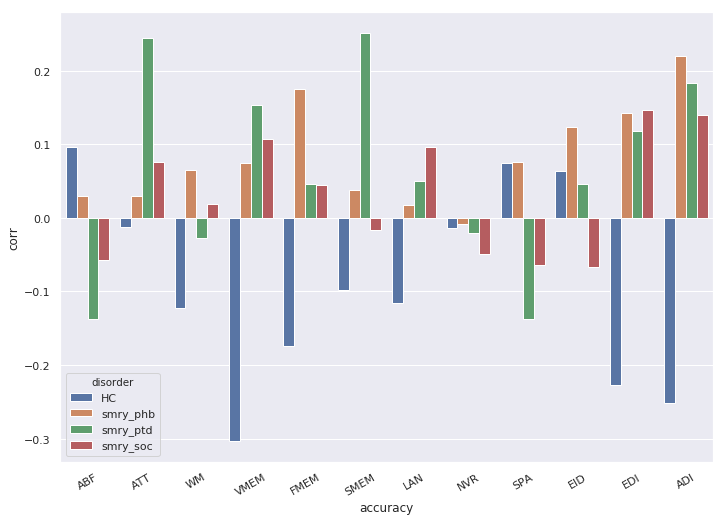

In [12]:

plot_data = pd.DataFrame(result).iloc[0:12,:]
plot_data['score'] = cog_label_acc2
plot_data = pd.melt(plot_data, id_vars=['score'], value_vars=disorders,
                   var_name = "disorder", value_name = "corr")

#print(plot_data)

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x = "score", y = "corr", hue = "disorder", data = plot_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel('accuracy')

Text(0.5,0,'speed')

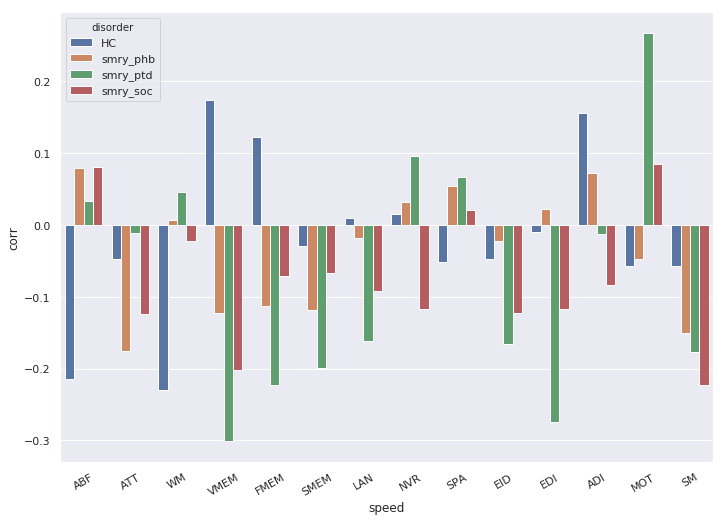

In [13]:

plot_data = pd.DataFrame(result).iloc[12:,:]
plot_data['score'] = cog_label_speed2
plot_data = pd.melt(plot_data, id_vars=['score'], value_vars=disorders,
                   var_name = "disorder", value_name = "corr")

#print(plot_data)

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x = "score", y = "corr", hue = "disorder", data = plot_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel('speed')

In [14]:
# permutation test of correlation:

n_perm = 500
d = {'cog_score': cog_score_label2}

for i_dis in range(len(disorders)):
    
    corr_perm = np.empty([n_perm, num_cog])
    
    for i in range(n_perm):
        
        y_dis = subject_behav_merge.loc[disorders[i_dis], 'age']
        y_pred = subject_behav_merge.loc[disorders[i_dis], 'predict age']
        age_gap = 1*(y_pred - y_dis)

        cog_score = subject_behav_merge.loc[disorders[i_dis], cog_score_label].values
        # np.random.shuffle shuffle the array in place
        age_gap_shuffle = age_gap.values
        np.random.shuffle(age_gap_shuffle)
        r_mat = pd.DataFrame(np.hstack((np.vstack(age_gap_shuffle), cog_score))).corr()

        corr_perm[i, :] = r_mat.loc[0, 1:num_cog+1].values

    #print(corr_mat_ptsd_perm)
    ## compute threshold for one tailed test at .05 level:
#     corr_perm_sort = np.sort(corr_perm, axis = 0)
#     print(corr_mat_ptsd_sort)
#     sig_idx = int(round(n_perm * .05, 0))
#     print(sig_idx)
#     sig_value = corr_perm_sort[sig_idx]
#     print(sig_value)

    ## compute significant level:
    corr_dis = corr_table.loc[:, disorders[i_dis]].values
    p_disorder = np.sum(np.absolute(corr_perm) > np.absolute(corr_dis), axis = 0)/n_perm

    d.update({disorders[i_dis]: p_disorder})

corr_p = pd.DataFrame(d)
# print(np.hstack((np.vstack(cog_score_label), np.vstack(p_ptsd), np.vstack(p_trauma))))

In [15]:
corr_p

,cog_score,HC,smry_phb,smry_ptd,smry_soc
0,ABF_Accuracy,0.480,0.668,0.314,0.480
1,ATT_Accuracy,0.932,0.656,0.052,0.370
2,WM_Accuracy,0.362,0.366,0.848,0.810
3,VMEM_Accuracy,0.016,0.326,0.272,0.182
4,FMEM_Accuracy,0.168,0.020,0.668,0.612
5,SMEM_Accuracy,0.442,0.600,0.048,0.862
6,LAN_Accuracy,0.366,0.826,0.728,0.248
7,NVR_Accuracy,0.914,0.914,0.846,0.540
8,SPA_Accuracy,0.534,0.306,0.276,0.456
9,EID_Accuracy,0.652,0.098,0.720,0.396


In [16]:
# run linear regression for all cog scores as IV:
# age_gap = W*cog_scores + c.
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

# Create linear regression object
regr = linear_model.LinearRegression()

for i_dis in range(len(disorders)):
    y_dis = subject_behav_merge.loc[disorders[i_dis], 'age']
    y_pred = subject_behav_merge.loc[disorders[i_dis], 'predict age']
    age_gap = 1*(y_pred - y_dis)
    
    cog_score = subject_behav_merge.loc[disorders[i_dis], cog_score_label].values
    
    y = np.vstack(age_gap.values)
    #y = np.vstack(y_pred.values)
    x = np.hstack((cog_score, np.vstack(y_dis.values))) # without factor scores.

    # print(y.shape)
    # print(x.shape)

    nan_rows = np.isnan(x).any(axis = 1)
    x = x[~nan_rows,:]
    y = y[~nan_rows]

    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()

    print(disorders[i_dis] + " y: age gap, x: cog_scores")
    print(est2.summary())


HC y: age gap, x: cog_scores
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     8.520
Date:                Fri, 22 Feb 2019   Prob (F-statistic):           5.26e-08
Time:                        16:04:03   Log-Likelihood:                -74.085
No. Observations:                  58   AIC:                             204.2
Df Residuals:                      30   BIC:                             261.9
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4915  

In [17]:
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn import preprocessing

def linear_regression_rfe(X, y, x_label, n_features = 5):    

    nan_idx = np.isnan(X).any(axis=1)
    y = y[~nan_idx]
    X = X[~nan_idx,:]
    X_scaled = preprocessing.scale(X)

    estimator = LinearRegression()
    #selector = RFECV(estimator, step=1, cv=5,  min_features_to_select=5)
    selector = RFECV(estimator, step=1, cv=5)
    #selector = RFE(estimator, step=1, n_features_to_select=n_features)
    
    selector = selector.fit(X_scaled, y)
    
    #print(selector.support_)
    #print(selector.ranking_)

    coefs = selector.estimator_.coef_
#     print(coefs)
    index = selector.support_
    selected_label = [x_label[i] for i in range(len(x_label)) if index[i]]
    
    rsquared = selector.score(X_scaled, y)
    
    coefs = pd.DataFrame(coefs, index = selected_label, columns = ['beta'])
    return((coefs, rsquared))

In [18]:
## run linear regression with rfe:

regression_rfe_result = []
regression_rfe_r2 = {}
for i_dis in range(len(disorders)):
    y_dis = subject_behav_merge.loc[disorders[i_dis], 'age']
    y_pred = subject_behav_merge.loc[disorders[i_dis], 'predict age']
    age_gap = 1*(y_pred - y_dis)
    
    cog_score = subject_behav_merge.loc[disorders[i_dis], cog_score_label].values
    
    y = age_gap.values
    #y = y_pred.values
    X = np.hstack((cog_score, np.vstack(y_dis.values))) # without factor scores.
    
    coefs, rsquared = linear_regression_rfe(X, y, cog_score_label2+['age'])
    regression_rfe_result.append(coefs)
    regression_rfe_r2.update({disorders_name[i_dis]: rsquared})


In [19]:
# save coefs:

regression_rfe_table = pd.concat(regression_rfe_result, keys = disorders_name, axis = 1, sort=False)
regression_rfe_table.columns = regression_rfe_table.columns.droplevel(1)

regression_rfe_r2_table = pd.DataFrame(regression_rfe_r2, index = ['rsquared'])
regression_rfe_table = pd.concat([regression_rfe_table, regression_rfe_r2_table])

regression_rfe_table.to_csv("result/disorders/regression_rfe_" + method + "_" + feature_name + ".csv")
regression_rfe_table

,HC,Specific Phobia,PTSD,Social Phobia
age,-2.193552,-1.370940,-1.331238,-1.177793
rsquared,0.736888,0.305187,0.307651,0.213998
